# 1D Gaussian Mixture Model

This notebook demonstrates how to use Gaussian Mixture Models to cluster 1D data distribution.

## Import Required Libraries

Import the necessary libraries including matplotlib, numpy, seaborn, and scipy.

In [1]:
# Import the required libraries.
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import gaussian_kde, norm

from scipy.signal import find_peaks

## Define Helper Functions

Create helper functions for density estimation, data splitting, statistical calculations, and plotting.

In [2]:
def estimate_density_and_split(
        data: np.ndarray, bandwidth: str="scott", num_points: int=1000
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Function to estimate the density of the data and split it into two groups.

    Args:
        data (np.ndarray): The data to estimate the density.
        bandwidth (str): The bandwidth method for the KDE.
        num_points (int): The number of points to estimate the density.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: The X-axis, KDE
            values, and two groups.
    """

    # Estimate the density using Kernel Density Estimation.
    kde = gaussian_kde(data, bw_method=bandwidth)
    x_values = np.linspace(np.min(data), np.max(data), num_points)
    kde_values = kde(x_values)

    # Find the peaks in the estimated density.
    peaks, _ = find_peaks(kde_values)

    # Determine the threshold for splitting data based on the peaks.
    if len(peaks) < 2:
        raise ValueError("Unable to find two peaks in the density estimation.")

    threshold = peaks.mean().astype(int)

    # Split the data into two groups based on the threshold.
    group1 = data[:threshold]
    group2 = data[threshold:]

    return x_values, kde_values, group1, group2


def calculate_group_statistics(
        group: np.ndarray, kde_values: np.ndarray) -> Tuple[list, list]:
    """
    Function to calculate the mean and covariance of the given group.

    Args:
        group (np.ndarray): The group to calculate the statistics.
        kde_values (np.ndarray): The KDE values of the group.

    Returns:
        Tuple[list, list]: The mean and covariance of the group.
    """

    # Calculate the mean and covariance for the given group.
    mean = np.mean(group)
    covariance = np.cov(group), np.cov(kde_values)

    # Format the mean and covariance as 2D for multivariate generation.
    formatted_mean = [ mean, 0 ]
    formatted_covariance = [ [covariance[0], covariance[1]],
                             [covariance[1], covariance[0]] ]

    return formatted_mean, formatted_covariance


def plot_data_and_density(data1: np.ndarray, data2: np.ndarray):
    """
    Function to plot the generated data and KDE contours.

    Args:
        data1 (np.ndarray): The first group of data.
        data2 (np.ndarray): The second group of data.
    """

    # Plot the generated data and KDE contours.
    plt.scatter(
        data1[:, 0], data1[:, 1], label="Data Distribution 1",
        c=colors[1], edgecolor=colors[-1], alpha=0.6
    )
    plt.scatter(
        data2[:, 0], data2[:, 1], label="Data Distribution 2",
        c=colors[2], edgecolor=colors[-1], alpha=0.6
    )

    sns.kdeplot(
        x=data1[:, 0], y=data1[:, 1], levels=20,
        color=colors[-1], alpha=0.3
    )
    sns.kdeplot(
        x=data2[:, 0], y=data2[:, 1], levels=20,
        color=colors[-1], alpha=0.3
    )

    plt.title("Multivariate Normal Distribution")
    plt.xlabel("Values Covariance")
    plt.ylabel("KDE Covariance")
    plt.legend()
    plt.grid(True)


def plot_pdf(data: np.ndarray, mu: float, sigma: float, label: str,
             alpha: float=0.6, density: bool=True, color: str="green",
             edgecolor: str="black"):
    """
    Plot the histogram of 1-D data generated from a normal distribution and its
    PDF curve.

    Args:
        data (np.ndarray): The 1-D data generated from a normal distribution.
        mu (float): The mean of the normal distribution.
        sigma (float): The standard deviation of the normal distribution.
        label (str): The label for the plot.
        alpha (float): The transparency of the histogram.
        density (bool): Whether to plot the density or frequency.
        color (str): The color of the histogram.
    """

    # Update the label with the mean and standard deviation.
    if label is not None:
        label = f"{label}: μ={mu:.2f}, σ={sigma:.2f}"

    # Plot the histogram.
    plt.hist(
        data, bins=50, density=density, alpha=alpha,
        label=label,
        color=color, edgecolor=edgecolor
    )

    # Plot the PDF.
    x = np.linspace(data.min(), data.max(), 1000)
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, "--", color=edgecolor)

    # Add labels and legend.
    plt.xlabel("Value")
    plt.ylabel("Density" if density else "Frequency")
    plt.legend(loc="upper left")
    plt.grid(True)


def plot_intermediate_steps(
        distributions: list, means: np.ndarray, variances: np.ndarray
    ):
    """
    Plot intermediate steps of the EM algorithm, showing the updated
    distributions.

    Args:
        distributions (list): The data to plot the original distributions.
        means (np.ndarray): The means of the components.
        variances (np.ndarray): The variances of the components.
    """

    # Plot the original distributions.
    for i, (distribution, mu) in enumerate(zip(distributions, [-2, 2])):
        plot_pdf(
            distribution, mu, 1, alpha=0.3, label="Original Distribution",
            color=colors[3], edgecolor=colors[3]
        )

    # Plot updated distributions for the current step.
    for i, (mu, sigma) in enumerate(zip(means, variances)):
        random_dist = norm.rvs(mu, sigma, size=500)
        plot_pdf(
            random_dist, mu, sigma, label="Updated Distribution",
            color=colors[i+1], edgecolor=colors[-1]
        )


def random_init(
        data: np.ndarray, n_components: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Initialize means, weights, and variances randomly for Gaussian Mixture
    Models.

    Args:
        data (np.ndarray): The data to initialize the components.
        n_components (int): The number of components to initialize.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: The initialized means,
            variances, and weights.
    """

    # Initialize weights to be uniform.
    weights = np.ones(n_components) / n_components

    # Randomly choose initial means from the data.
    means = np.random.choice(data, n_components)

    # Initialize variances randomly.
    variances = np.random.random_sample(size=n_components)

    # Plot the initial distributions.
    for i in range(n_components):
        random_dist = norm.rvs(means[i], variances[i], size=500)
        plot_pdf(
            random_dist, means[i], variances[i], label=f"Random Init {i + 1}",
            color=colors[i + 1], edgecolor=colors[-1]
        )

    return means, variances, weights


def expectation_step(
        data: np.ndarray, n_components: int,
        means: np.ndarray, variances: np.ndarray
    ) -> np.ndarray:
    """
    E-step of the Expectation-Maximization algorithm for Gaussian Mixture
    Models.
    
    Args:
        data (np.ndarray): The data to compute the weights.
        n_components (int): The number of components.
        means (np.ndarray): The means of the components.
        variances (np.ndarray): The variances of the components.

    Returns:
        np.ndarray: The computed weights for the data.
    """

    # Initialize the weights matrix.
    weights = np.zeros((n_components, len(data)))

    # Compute the probability density function for each component.
    for i in range(n_components):
        pdf_values = norm(loc=means[i], scale=np.sqrt(variances[i])).pdf(data)
        weights[i, :] = pdf_values

    # Normalize the weights across the components to sum to 1 for each data
    # point.
    weights /= np.sum(weights, axis=0)

    return weights


def maximization_step(
        data: np.ndarray, weights: np.ndarray, n_components: int, pi: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    M-step of the Expectation-Maximization algorithm for Gaussian Mixture Models.
    
    Args:
        data (np.ndarray): The data to update the components.
        weights (np.ndarray): The weights of the components.
        n_components (int): The number of components.
        pi (np.ndarray): The mixing coefficients of the components.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: The updated means, variances,
            and mixing coefficients.
    """

    # Initialize the new means, variances, and mixing coefficients.
    means = np.zeros(n_components)
    variances = np.zeros(n_components)
    new_pi = np.zeros(n_components)

    # Update the responsibilities for normalization.
    r = np.zeros_like(weights)
    for i in range(n_components):
        r[i, :] = (weights[i, :] * pi[i]) / np.sum(
            weights * pi[:, np.newaxis], axis=0
        )

        # Update the mean for component i.
        means[i] = \
            np.sum(r[i, :] * data) / np.sum(r[i, :])

        # Update the variance for component i.
        variances[i] = \
            np.sum(r[i, :] * (data - means[i])**2) / np.sum(r[i, :])

        # Update the mixing coefficient for component i.
        new_pi[i] = np.mean(r[i, :])

    return means, variances, new_pi

## Define Colors and Generate 1D Gaussian Data

Define custom colors and generate 1D data from two Gaussian distributions.

In [3]:
# Define the number of bins and seed.
np.random.seed(42)

# Define the colors to be used in the plot.
colors = [
    "#2580B7", # Blue
    "#179E86", # Dark Green
    "#F59B11", # Yellow
    "#C03B26", # Red
    "#633248", # Brown
    "#44546A", # Gray
]

# Generate a 1D distributions with 1000 samples.
data = np.concatenate([
    np.random.normal(loc=-2, scale=1, size=500),
    np.random.normal(loc=2, scale=1, size=500)
])

## Visualize 1D Gaussian Distributions

Plot the histogram and KDE of the combined 1D Gaussian distributions.

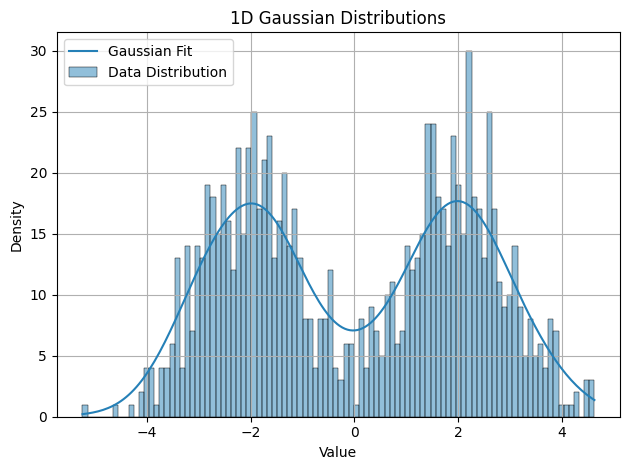

In [4]:
# Plot the data using seaborn's distplot function.
sns.histplot(
    data, kde=True, bins=100, color=colors[0], alpha=0.5
)

plt.title("1D Gaussian Distributions")
plt.legend(["Gaussian Fit", "Data Distribution"])
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

## Estimate Density and Split Data

Use kernel density estimation to split the data into two groups based on peaks.

In [5]:
# Estimate density and split data into two groups.
x_values, kde_values, group1, group2 = estimate_density_and_split(data)

# Calculate statistics for each group.
mean1, cov1 = calculate_group_statistics(group1, kde_values[:len(group1)])
mean2, cov2 = calculate_group_statistics(group2, kde_values[len(group1):])

# Generate multivariate data for each group.
data1 = np.random.multivariate_normal(mean1, cov1, 500)
data2 = np.random.multivariate_normal(mean2, cov2, 500)

## Visualize Multivariate Normal Distribution

Plot the multivariate data with KDE contours.

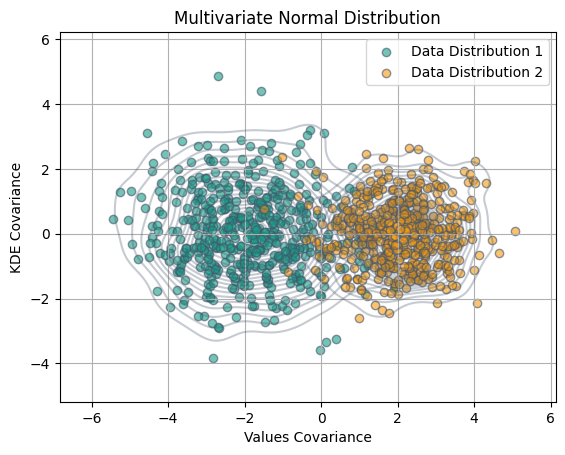

In [6]:
# Plot the data and density contours
plot_data_and_density(data1, data2)
plt.show()

## Plot Probability Density Functions

Visualize the PDF for each data distribution group.

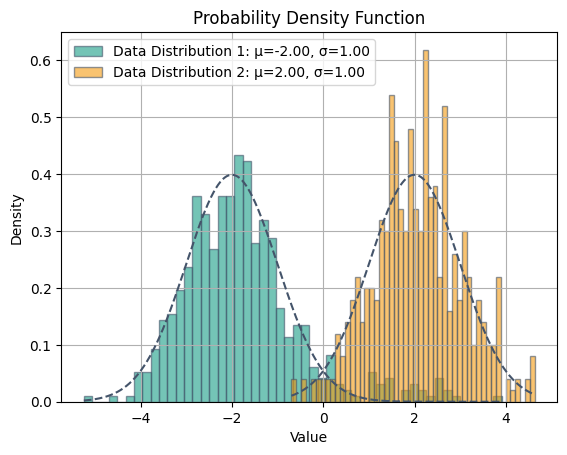

In [7]:
# Plot the probability density of each sample.
plot_pdf(group1, -2, 1, "Data Distribution 1",
         color=colors[1], edgecolor=colors[-1])
plot_pdf(group2, 2, 1, "Data Distribution 2",
         color=colors[2], edgecolor=colors[-1])
plt.title("Probability Density Function")
plt.show()

## Initialize Gaussian Mixture Model

Randomly initialize the GMM components with means, variances, and mixing coefficients.

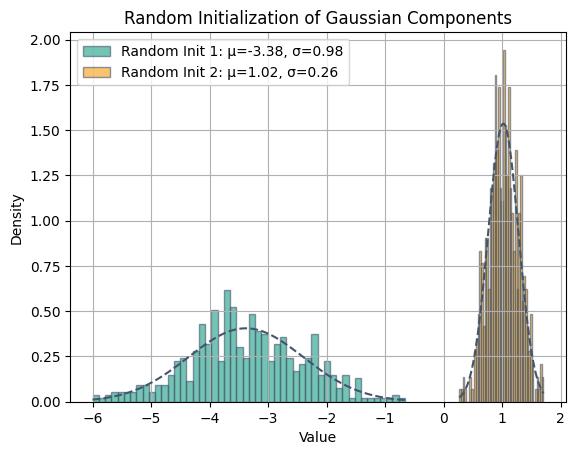

In [8]:
# Number of training steps and components for the GMM.
N_STEPS = 30
N_COMPONENTS = 2

# Initialize the Gaussian Mixture Model components.
prev_means, prev_variances, pi = random_init(data, N_COMPONENTS)
plt.title("Random Initialization of Gaussian Components")
plt.show()

## Run EM Algorithm

Execute the Expectation-Maximization algorithm to fit the Gaussian Mixture Model.

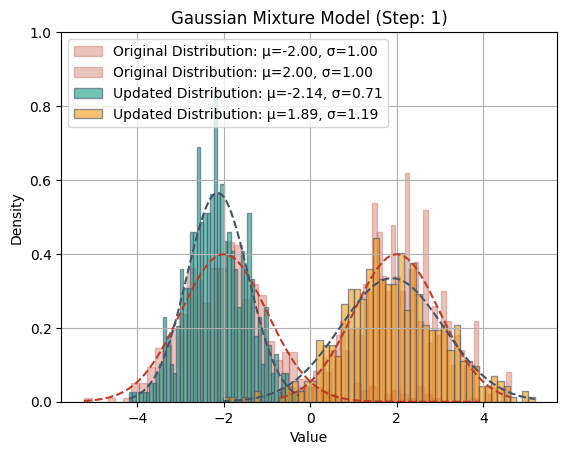

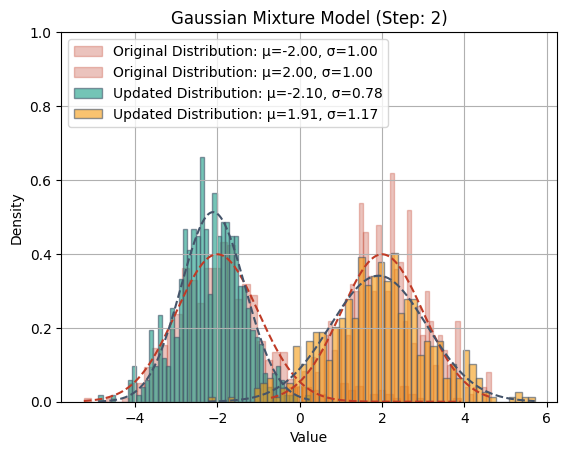

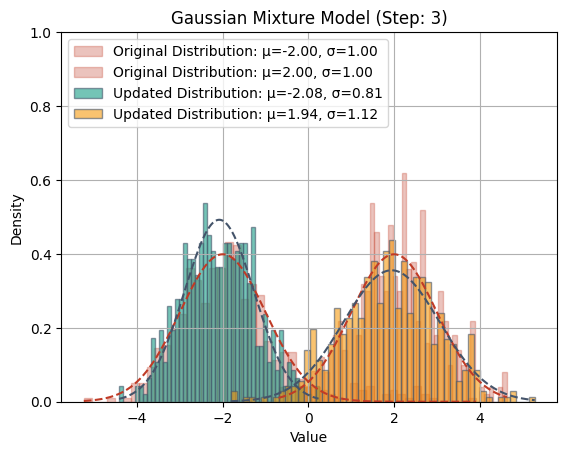

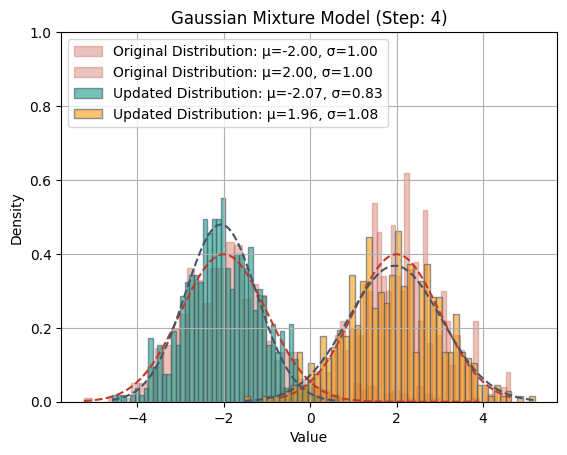

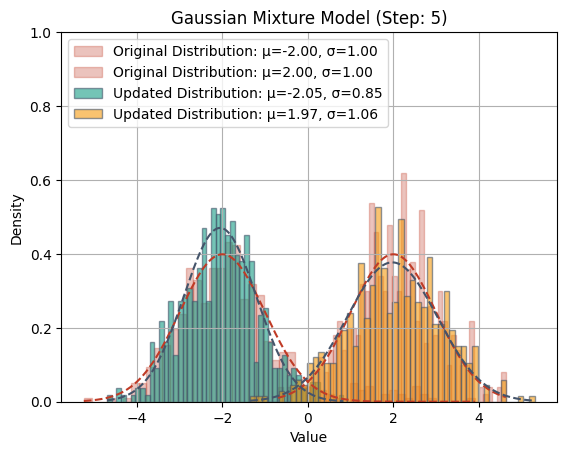

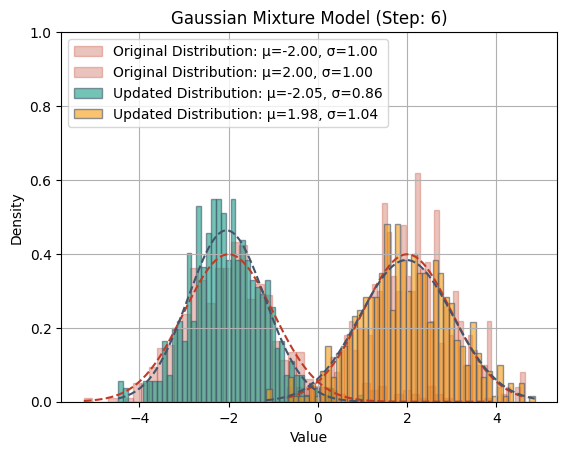

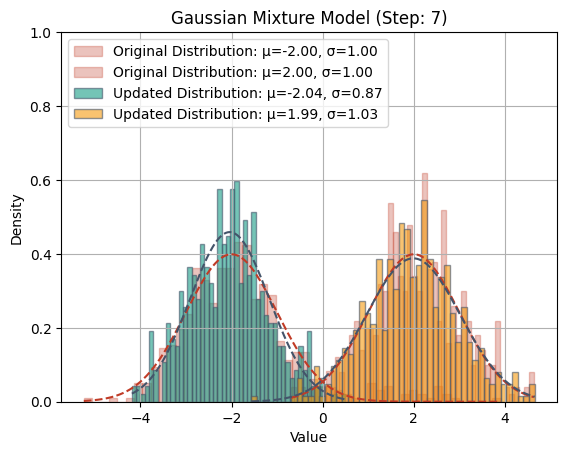

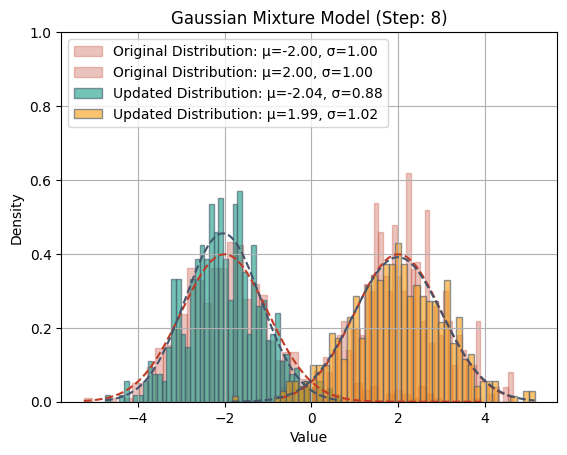

Converged at step 8.


In [9]:
for step in range(N_STEPS):

    # E-Step: Compute the weights (responsibility matrix).
    weights = expectation_step(data, N_COMPONENTS, prev_means, prev_variances)

    # M-Step: Update the means, variances, and mixing coefficients.
    means, variances, pi = maximization_step(data, weights, N_COMPONENTS, pi)

    # Plot the intermediate steps.
    plot_intermediate_steps([group1, group2], means, variances)
    plt.title(f"Gaussian Mixture Model (Step: {step + 1})")
    plt.ylim(0, 1)
    plt.show()

    # Check for convergence: stop if the means and variances don't change
    # significantly.
    if (np.allclose(means, prev_means, atol=1e-2) and
        np.allclose(variances, prev_variances, atol=1e-2)):
        print(f"Converged at step {step + 1}.")
        break

    # Update previous means and variances for the next iteration.
    prev_means = means.copy()
    prev_variances = variances.copy()

## Visualize Final GMM Result

Display the final fitted Gaussian Mixture Model.

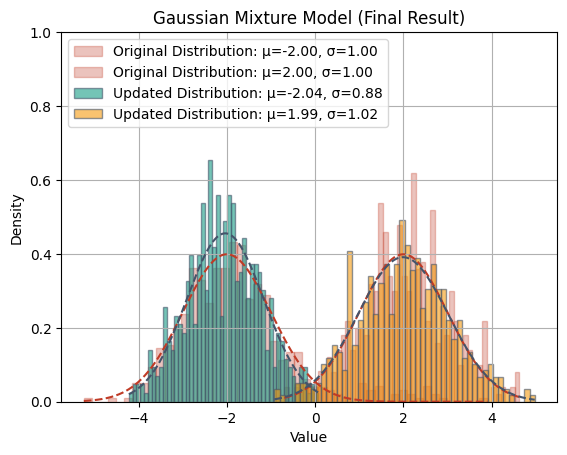

In [10]:
# Plot the final result.
plot_intermediate_steps([group1, group2], means, variances)
plt.title("Gaussian Mixture Model (Final Result)")
plt.ylim(0, 1)
plt.show()